### Feature Engineering - Geo Clustering

We want to capture the geographic relationship between observations, however, if we create labelled clusters, we will have to OHE them before apply our model. This will create issues with live data because when we run our clustering algorithm on live data, the dataset is much smaller and will be unlikely to create as many clusters or the same clusters as our training data set, this will break our model.

So we decided to create clustsers using HDBScan, but only save the binary information of "does this observation belong to a cluster?"

This means that we know that some points have relationships with other points, and this feature is unlikely to break our model.

In [1]:
import pandas as pd
import numpy as np
import warnings
import hdbscan
warnings.filterwarnings('ignore')

def process_live_data_and_cluster(original_df):
    """
    Pre processes live data to match pipeline expectations.
    """
    df = original_df.copy()
    df['acq_date'] = pd.to_datetime(df['acq_date'])
    df['satellite'] = df['satellite'].replace({'T':'Terra', 'A': 'Aqua'})
    df['latitude'] = df['latitude'].round(2)
    df['longitude'] = df['longitude'].round(2) 
    
    df['month'] = df['acq_date'].dt.month
    df['week'] = df['acq_date'].dt.weekofyear
    df.drop(columns=['acq_date', 'acq_time'], inplace=True)
    
    #add binary cluster label
    clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=20, gen_min_span_tree=True)
    df['clusters'] = clusterer.fit(df[['latitude','longitude']]).labels_
    df['clusters'] = df['clusters'].apply(lambda x: False if x == -1 else True)
    
    
    return df



X_train = process_live_data_and_cluster(pd.read_pickle('~/datascience/burn notice/Data-Science/Data/Cleaned_Modus_Historical/X_train_small.pkl'))
y_train = (pd.read_pickle('~/datascience/burn notice/Data-Science/Data/Cleaned_Modus_Historical/y_train_small.pkl'))
X_test = process_live_data_and_cluster(pd.read_pickle('~/datascience/burn notice/Data-Science/Data/Cleaned_Modus_Historical/X_test_small.pkl'))
y_test = (pd.read_pickle('~/datascience/burn notice/Data-Science/Data/Cleaned_Modus_Historical/y_test_small.pkl'))

### Add clustering to our OHE column transformer

In [2]:
# scikit-learn pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# feature processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# deals with one hot encoding
ohe_features = ['satellite', 'daynight', 'month', 'week', 'clusters']
# scaler
scale_features = ['brightness', 'track', 'scan', 'bright_t31', 'frp'] #removed confidence

preprocessor = make_column_transformer(
    (OneHotEncoder(), ohe_features),
    (StandardScaler(), scale_features), remainder='drop')

### Pipeline with the same DTC as our baseline model

In [3]:
from sklearn.tree import DecisionTreeClassifier

random_state = 314

pipe =  make_pipeline(preprocessor,
            DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=10, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=random_state,
             splitter='best'))
            
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('onehotencoder', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
    ...       min_weight_fraction_leaf=0.0, presort=False, random_state=314,
            splitter='best'))])

In [4]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, recall_score

y_pred_proba = pipe.predict_proba(X_test)[:,1]
y_pred = pipe.predict(X_test)

print('ROC: ', roc_auc_score(y_test, y_pred_proba))
print('f1: ', roc_auc_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))

ROC:  0.6433774117769712
f1:  0.6055546227753781
recall:  0.46081898923209935


Our scoring is significantly better than our baseline model, so the clustering metric has improved our model.

In [5]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def normalized_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred) 
    #normalize cm
    array = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(array, range(2),
                      range(2))
    #plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4)#for label size
    ax = sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})#.set_title('Normalized confusion matrix')# font size
    ax.set(xlabel='Predicted Fires', ylabel='True Fires', title = title)
    plt.show();

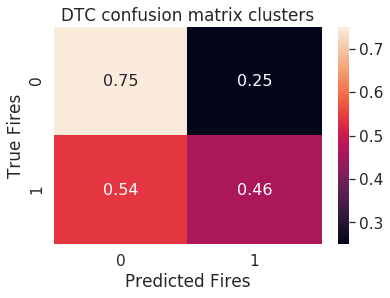

In [6]:
normalized_confusion_matrix(y_test, y_pred, 'DTC confusion matrix clusters')

This is significantly better than our baseline confusion matrix in terms of our true positive rate, so the feature is usefule.

![alt text](DTC_Baseline_CM.png)

### Now confirm that this feature doesn't break with live data

In [7]:
# let's test this on new data and see if the pipeline breaks
modis_url = 'https://firms.modaps.eosdis.nasa.gov/data/active_fire/c6/csv/MODIS_C6_USA_contiguous_and_Hawaii_24h.csv'
modis = process_live_data_and_cluster(pd.read_csv(modis_url))

In [11]:
X_train.clusters.value_counts()

True     147897
False     70107
Name: clusters, dtype: int64

In [10]:
modis.clusters.value_counts()

True     480
False     93
Name: clusters, dtype: int64

In [13]:
# y_pred = 
pipe.predict(modis)

array([0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Binary Clustering improved DTC model performance by a significant amount and doesn't kill our live model. We will deploy this.